# **vitz_john_finaltermproj**

**Name:** John Vitz

**UCID:** jhv6

**Email Address:** jhv6@njit.edu

**Class:** CS 634-101

**Professor:** Yasser Abdullah

**Date:** November 24, 2024

# 1. Final Project - Data Mining

**Github Repository Link:**

https://github.com/VitzJ/CS634-Data-Mining-Final-Project
<br>
<br>
The dataset for this project is comprised of questions from the website https://www.quora.com/.
<br>
<br>
Quora is an internet forum that allows users to ask and answer each other's questions. In 2019, the website submitted a dataset comprised of 1.3+ million unique different questions along with an attached target label to a kaggle competition with the goal of leveraging the power of the kaggle community to come up with machine learning and natural language processing solutions to the following problem:
<br>
<br>
**How can we tell whether or not a question is sincere?**
<br>
<br>

For this project, I utilized 3 different machine learning algorithms in order to perform basic binary classification.
<br>
<br>
- 1. Random Forest (Required)
- 2. Bi-Directional LSTM (Additional Option: Deep Learning)
- 3. Naive Bayes (Additional Option: Algorithms)
<br>
<br>

I also included a Logistic Regression model for comparison. The goal of utilizing these models was to examine various classification task metrics across models utilizing 10 fold cross validation in order to learn about their implementation as well as how to interpret them in the context of machine learning models.

The zip file folder **readme.txt** / the github **readme.md** contain a detailed tutorial on how to run the python source file **vitz_john_finaltermproj.py** in the command prompt terminal.

## 1.1 Data Source, Data Description, Data Loading, and Imports

**Data Source:** https://www.kaggle.com/c/quora-insincere-questions-classification/data
<br>
<br>

### Important Data Pre-Processing Information:

The data was extremely large, so I was forced to cut the size down very substantially. I cut it down to a small subset utilizing the following code:

```py
train = pd.read_csv('/content/train.csv')

# I want to get rid of questions that are below a choice groups of characters long
# because I don't think they will be valuable for training models, I want the
# limited data to contain at least 5 groups of characters.
min_chars = 5

num_train = 2500 # 2500 train values
num_test = int(num_train * 0.1) # 250 total test values

pos_neg_split = 0.5 # 50/50 class split

pos_train = int(num_train * pos_neg_split)
neg_train = num_train - pos_train

pos_test = int(num_test * pos_neg_split)
neg_test = num_test - pos_test

train['length'] = (train['question_text'].str.split().str.len())
train = train[train['length'] >= min_chars].copy()

test = pd.concat([train[train['target'] == 0][pos_train: pos_train + pos_test].copy(),
                  train[train['target'] == 1][neg_train: neg_train + neg_test].copy()],
                  axis=0)

train = pd.concat([train[train['target'] == 0][:pos_train].copy(),
                   train[train['target'] == 1][:neg_train].copy()],
                   axis=0)

train.to_csv(f'vitz_john_finaltermproj_train_set.csv', index=False)
test.to_csv(f'vitz_john_finaltermproj_test_set.csv', index=False)

train = pd.read_csv(f'vitz_john_finaltermproj_train_set.csv')
test = pd.read_csv(f'vitz_john_finaltermproj_test_set.csv')
```

The train.csv file from the previously mentioned source: https://www.kaggle.com/c/quora-insincere-questions-classification/data?select=train.csv

The data is filtered based on class membership, and then the number of training and testing points are selected from the subset. This is done in order to assure that the new subset will have balanced class membership.

### Data Class and Fields Description
<br>

#### Dataset Overview

- **Number of questions in train:** 2500
- **Number of questions in test:** 250 (10% of amount of questions in the train data)

<br>

#### Target Values

There are two possible values for the `target` field:

- **0**: Indicates that the given question **is not** insincere.
- **1**: Indicates that the given question **is** insincere.

<br>

#### Data Fields

- **qid**: Unique question identifier
- **question_text**: Quora question text
- **target**: A question labeled "insincere" has a value of 1, otherwise 0


### Required Imports


| **Package Name**  | **Package Version** | **Website**                          |
|-------------------|---------------------|--------------------------------------|
| pandas            | 2.2.2               | [https://pandas.pydata.org/](https://pandas.pydata.org/) |
| numpy             | 1.26.4              | [https://numpy.org/](https://numpy.org/) |
| matplotlib        | 3.8.0               | [https://matplotlib.org/](https://matplotlib.org/) |
| scikit-learn      | 1.5.2               | [https://scikit-learn.org/stable/](https://scikit-learn.org/stable/) |
| torch             | 2.5.1               | [https://pytorch.org/](https://pytorch.org/) |
| nltk              | 3.9.1               | [https://www.nltk.org/](https://www.nltk.org/) |


In [32]:
# data structures/display methods imports
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.model_selection import KFold
from sklearn.feature_extraction.text import TfidfVectorizer

# model imports
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
from sklearn.naive_bayes import MultinomialNB

# neural network model imports
import torch
import torch.nn as nn
import torch.autograd as autograd
import torch.optim as optim
import torch.nn.functional as F

# metrics imports
from sklearn.metrics import roc_auc_score, roc_curve
from sklearn.metrics import auc

# string methods imports
import nltk # https://www.nltk.org/data.html
nltk.download('stopwords')
from nltk.corpus import stopwords
import re # regular expressions library builtin
import string # string library builtin

[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


In [33]:
train = pd.read_csv(f'vitz_john_finaltermproj_train_set.csv')
test = pd.read_csv(f'vitz_john_finaltermproj_test_set.csv')

In [34]:
train.head()

,qid,question_text,target,length
0,00002165364db923c7e6,How did Quebec nationalists see their province...,0,13
1,000032939017120e6e44,"Do you have an adopted dog, how would you enco...",0,16
2,0000412ca6e4628ce2cf,Why does velocity affect time? Does velocity a...,0,10
3,000042bf85aa498cd78e,How did Otto von Guericke used the Magdeburg h...,0,9
4,0000455dfa3e01eae3af,Can I convert montra helicon D to a mountain b...,0,15


In [35]:
grouped_lengths = train.groupby('target')['length'].agg(['count', 'min', 'max', 'median', 'mean', 'std'])
print(f'\nA comparison of the train set length of character groups before cleaning: \n')
print(grouped_lengths, '\n')


A comparison of the train set length of character groups before cleaning: 

        count  min  max  median     mean       std
target                                            
0        1250    5   50    11.0  12.6632  6.758514
1        1250    5   51    15.0  17.3864  9.341933 



## 1.2 Data Handling and Cleaning Information

I utilized multiple techniques such as lowercasing, removing particular components of text, removing links, punctuation, and removing words containing numbers. I also removed stopwords through nltk and utilized a technique call stemming on the data. I applied both of these processes to the train set and the test set while maintaining their independence from each other. This was done with the purpose of standardizing the text to allow for more concentration into the vectorization.

In [36]:
# Special thanks to https://www.kaggle.com/tanulsingh077 for this function

def clean_text(text):
    '''Make text lowercase, remove text in square brackets,remove links,remove punctuation
    and remove words containing numbers.'''

    text = str(text).lower()
    text = re.sub('\[.*?\]', '', text)
    text = re.sub('https?://\S+|www\.\S+', '', text)
    text = re.sub('<.*?>+', '', text)
    text = re.sub('[%s]' % re.escape(string.punctuation), '', text)
    text = re.sub('\n', '', text)
    text = re.sub('\w*\d\w*', '', text)

    return text

### Removal of Stopwords

Can try with and without. In an effort to reduce computational requirements for this project, I will try removing stopwords.

In [37]:
stop_words = list(set(stopwords.words('english'))) # uses nltk
#print(stop_words)

In [38]:
def remove_stopwords(text):
  text = ' '.join(word for word in text.split(' ') if word not in stop_words)
  return text

### Stemming

Stemming - chopping off the ends of words in hopes to remove derivational affixes, such as trying to get words like 'adjustably' and 'adjustable' to be recognized under the same umbrella 'adjust' which is the root word by removing terms such as 'ably' and 'able' from the word.

In [39]:
stemmer = nltk.SnowballStemmer("english")

def stemm_text(text):
    text = ' '.join(stemmer.stem(word) for word in text.split(' '))
    return text

### Clean Punctuation, Remove Stopwords, and Stemm all words in the data.

In [40]:
def preprocess_data(text):
  # Clean puntuation, urls, and so on
  text = clean_text(text)
  # Remove stopwords
  text = ' '.join(word for word in text.split(' ') if word not in stop_words)
  # Stemm all the words in the sentence
  text = ' '.join(stemmer.stem(word) for word in text.split(' '))

  return text

In [41]:
# Apply the cleaning to the train set
train['question_text'] = train['question_text'].apply(preprocess_data)

# Apply the same cleaning to the test set (without looking at it in any way)
test['question_text'] = test['question_text'].apply(preprocess_data)

In [42]:
train['new_length'] = (train['question_text'].str.split().str.len())
grouped_newlengths = train.groupby('target')['new_length'].agg(['count', 'min', 'max', 'median', 'mean', 'std'])
print(f'\nA comparison of the length of character groups after cleaning: \n')
print(grouped_newlengths, '\n')
avg_words_removed = sum(train['length'] - train['new_length']) / train.shape[0]
print(f'\nAverage number of words removed after cleaning: {avg_words_removed}\n\n')


A comparison of the length of character groups after cleaning: 

        count  min  max  median    mean       std
target                                           
0        1250    1   26     5.0  6.2712  3.393474
1        1250    2   27     8.0  9.0912  4.863189 


Average number of words removed after cleaning: 7.3436




## 1.3 Data Loading and Metrics Helper Functions

I utilize sklearn KFold to generate a 10 fold split for 10 fold cross validation. I also declare a few helper functions.

### K-Fold Cross Validation Splits

I have to make sure that when I use vectorizors / train models, I don't use the test fold to train the model, so I have to cut out the test data seperately each time.

In [43]:
X_train = train['question_text'].values
y_train = train['target'].values

X_test = test['question_text'].values
y_test = test['target'].values

K_fold_CV = KFold(n_splits=10, shuffle=True, random_state=42)
K_fold_CV.get_n_splits(X_train)

10

### Helper Functions

#### Get Metrics For Models

The **get_metrics()** function processes y_test (groud truth vector), prediction (model prediction vector), prediction probabilities (model prediction probabilities vector), and nn_bool (boolean to handle neural network inputs). It returns a labeled pandas dataframe consisting of the various metrics computed through the function.

In [44]:
# Metrics from https://njit.instructure.com/courses/42753/files/6730397?module_item_id=1417132

def get_metrics(y_test, prediction, prediction_probabilities, nn_bool=False):

  # TP: actual is 1, predicted is 1
  TP = sum(((np.array(y_test) == 1) & (np.array(prediction) == 1)) & (np.array(y_test) == 1)) # True Positives

  # TN: actual is 0, predicted is 0
  TN = sum(((np.array(y_test) == 0) & (np.array(prediction) == 0)) & (np.array(y_test) == 0)) # True Negatives

  # FP: actual is 0, predicted is 1, type II error
  FP = sum(((np.array(y_test) == 0) & (np.array(prediction) == 1)) & (np.array(y_test) == 0)) # False Positives

  # FN: actual is 1, predicted is 0, type I error
  FN = sum(((np.array(y_test) == 1) & (np.array(prediction) == 0)) & (np.array(y_test) == 1)) # False Negatives

  # Handle division by zero with 0 as default value

  TPR = 0 if (TP + FN) == 0 else TP / (TP + FN)  # True Positive Rate | Recall / Sensitivity

  TNR = 0 if (TN + FP) == 0 else TN / (TN + FP)  # True Negative Rate | Specificity

  FPR = 0 if (TN + FP) == 0 else FP / (TN + FP)  # False Positive Rate

  FNR = 0 if (TP + FN) == 0 else FN / (TP + FN)  # False Negative Rate

  Precision = 0 if (TP + FP) == 0 else TP / (TP + FP)  # Precision

  F1_measure = 0 if (((2 * TP) + FP + FN) == 0) else (2 * TP) / ((2 * TP) + FP + FN)  # F1 Measure

  Accuracy = 0 if (TP + FP + TN + FN) == 0 else (TP + TN) / (TP + FP + TN + FN)  # Accuracy

  Error_rate = 0 if (TP + FP + TN + FN) == 0 else (FP + FN) / (TP + FP + TN + FN)  # Error rate

  BACC = (TPR + TNR) / 2 # Balanced Accuracy

  TSS = TPR - FPR # True Skill Statistics

  HSS = (2 * ((TP * TN) - (FP * FN))) / (((TP + FN) * (FN + TN)) + ((TP + FP) * (FP + TN))) # Heidke Skill Score

  if nn_bool:
    ### FOR LSTM ###
    # The values are all close to 0.5, which means that the model has likely not actually learned anything
    # from the data and is just adding in random noise for the predictions. Our classes are balanced for the chopped
    # data, so the naive prediction from BS_Naive is actually equal to the class proportions (50% 0, 50% 1). What this
    # means is that when comparing in BSS we get close to 1 because our model's output is very close to being Naive
    # this basically means the model isn't really learning much if at all.

    # Brier_Score = MSE between expected probabilities and predicted probabilities
    BS = (1 / y_test.shape[0]) * torch.sum(((y_test - prediction_probabilities) ** 2)) # (1 / N) * sum((y_test - prediction_probabilities) ** 2)
    BS = BS.item()

    # Brier Skill Score = likelihood of an event to happen or BS / BS (Naive) where BS (Naive)
    # uses the average probability of class membership instead of prediction_probabilities
    BS_Naive = ((1 / y_test.shape[0])) * torch.sum((y_test - (torch.sum(y_test) / y_test.shape[0])) ** 2) # (1 / N) * (sum(y_test - mean(y_test) ** 2))
    BS_Naive = BS_Naive.item()

  else:
    # Brier_Score = MSE between expected probabilities and predicted probabilities
    BS = (1 / len(y_test)) * sum(((y_test - prediction_probabilities) ** 2)) # (1 / N) * sum((y_test - prediction_probabilities) ** 2)

    # Brier Skill Score = likelihood of an event to happen or BS / BS (Naive) where BS (Naive)
    # uses the average probability of class membership instead of prediction_probabilities
    BS_Naive = ((1 / len(y_test))) * sum((y_test - (sum(y_test) / len(y_test))) ** 2) # (1 / N) * (sum(y_test - mean(y_test) ** 2))

  BSS = BS / BS_Naive

  NPV = 0 if (TN + FN) == 0 else TN / (TN + FN) # Negative Predictive Value

  FDR = 0 if (FP + TP) == 0 else FP / (FP + TP) # False Discovery Rate

  ROC_AUC_SCORE = roc_auc_score(y_test, prediction_probabilities)

  final_metrics = [TP, TN, FP, FN, TPR, TNR, FPR, FNR,
                   Precision, F1_measure, Accuracy, Error_rate,
                   BACC, TSS, HSS, BS, BSS, NPV, FDR, ROC_AUC_SCORE]

  final_metrics_labels = ['TP', 'TN', 'FP', 'FN', 'TPR', 'TNR', 'FPR', 'FNR',
                          'Precision', 'F1_measure', 'Accuracy', 'Error_rate',
                          'BACC', 'TSS', 'HSS', 'BS', 'BSS', 'NPV', 'FDR',
                          'ROC_AUC_SCORE']

  return pd.DataFrame(data=final_metrics, index=final_metrics_labels)

#### Metrics Per Iteration and Average Metrics

The function **metrics_per_iteration** reshapes the metrics stored in the pandas dataframes from **get_metrics()** into a format that arranges the metrics by model and then by fold.


In [45]:
def metrics_per_iteration(input_metrics, num_folds=10, verbose=True):
  #iterations = list(range(num_folds))
  columns = input_metrics[0].columns.to_list()

  new_dfs = []

  for model_col in columns:

    temp_df = pd.DataFrame()

    for k in range(num_folds):
      #print(input_metrics[k])
      temp_df[f'Fold{k + 1}'] = input_metrics[k][model_col]

    new_dfs.append(temp_df)

    if verbose:
      print(f'Metrics for {model_col}:')
      print(new_dfs[-1], '\n')

  return new_dfs


The function **average_metrics** simply returns the metrics for each model averaged across all of the folds.

In [46]:
def average_metrics(input_metrics, num_folds=10):
  avg_metrics = sum(input_metrics) / num_folds
  print('Average Metrics by Model')
  print(avg_metrics)
  return avg_metrics

## 1.4 Machine Learning Algorithms

For this project, I utilized 3 different machine learning algorithms in order to perform basic binary classification.
<br>
<br>
- 1. Random Forest (Required)
- 2. Bi-Directional LSTM (Additional Option: Deep Learning)
- 3. Naive Bayes (Additional Option: Algorithms)
<br>
<br>

I also included a Logistic Regression model for comparison.

In [47]:
from sklearn.naive_bayes import MultinomialNB

### Bi-Directional LSTM using pytorch

In this section, I construct a Bi-Directional LSTM using pytorch. The input is expanded tf-idf vectors. The model itself is extremely simple, because the training time is very long as is, and as I will explain in the final section, the input doesn't exactly return desireable results.

In [48]:
# Define a Bi-directional LSTM model for classification
class BiLSTMModel(nn.Module):

    def __init__(self, input_size, hidden_size, output_size):
        super(BiLSTMModel, self).__init__()
        # Bidirectional LSTM: set bidirectional=True
        self.lstm = nn.LSTM(input_size, hidden_size, batch_first=True, bidirectional=True)

        # Adjust the output size of the fully connected layer to account for the doubled hidden size
        self.fc = nn.Linear(hidden_size * 2, output_size)  # hidden_size * 2 because of bidirectional

    def forward(self, x):
        # LSTM layer
        lstm_out, (h_n, c_n) = self.lstm(x)  # lstm_out has shape (batch_size, seq_len, hidden_size * 2)

        # We use the output from the last timestep of the bidirectional LSTM
        out = lstm_out[:, -1, :]  # Get the output from the last timestep (for classification)

        # Apply fully connected layer
        out = self.fc(out)

        # Apply sigmoid for binary classification
        return torch.sigmoid(out)  # Sigmoid for binary classification, outputs range from [0, 1]

In [49]:
def fit_lstm(model, X_train_tensor, y_train_tensor, prediction_threshold=0.5, verbose=False):

  # Loss function and optimizer
  criterion = nn.BCELoss()  # Binary Cross-Entropy loss for binary classification
  optimizer = optim.Adam(model.parameters(), lr=0.001)

  # Training loop
  num_epochs = 5

  for epoch in range(num_epochs):
    model.train() # would be for if we had dropout/batch normalization layers
    optimizer.zero_grad() # clears gradients from previous epoch

    # Forward pass
    outputs = model(X_train_tensor) # Forward pass through the model
    loss = criterion(outputs, y_train_tensor) # Computes the loss between actual y and pred y

    # Backward pass and optimization
    loss.backward() # calculates the gradients (backprop)
    optimizer.step() # utilizes loss through the optimizer to update weights

    # Print loss every few epochs
    if verbose & ((epoch == 0) | ((epoch + 1) % 2 == 0) | ((epoch + 1) == num_epochs)):
        print(f"Epoch [{epoch+1}/{num_epochs}], Loss: {loss.item():.4f}")

  return model

## 1.5 TFIDF Vectorization output with All Machine Learning Models

The **all_models_tfidf_vectorize_10FoldCV()** function utilizes KFold splits to generate tf-idf vector representations of the train set from each respective split. It then passes the tfidf vector to each of the models, trains them, generates predictions, and the passes them to the **get_metrics** function.

**all_models_tfidf_vectorize_10FoldCV()** then records the metrics for each model for each fold, prints the metrics out for all models for the current fold, and repeats for each split until it finally returns a list of pandas dataframes (1 for each fold) on completion.

In [50]:
def all_models_tfidf_vectorize_10FoldCV():

  metrics = []

  for i, (train_index, test_index) in enumerate(K_fold_CV.split(X=X_train, y=y_train)):
    # declare models
    print(f"Fold {i + 1}:")

    # get fold train subsets (Note that X and y are global variables)
    temp_X_train = X_train[train_index]
    temp_y_train = y_train[train_index]

    # get fold test subsets (Note that X and y are global variables)
    temp_X_test = X_train[test_index]
    temp_y_test = y_train[test_index]

    # instantiate and fit the tf-idf vectorizer
    tfidf_vector = TfidfVectorizer(stop_words='english',
                            ngram_range=(1, 2),
                            norm="l2",
                            smooth_idf=True # prevents 0 divisions
                            #min_df=30, # lowest number of occurences required for words to be recorded in dtm
                            #max_df=0.7, # highest percentage threshold before words stop being recorded in dtm
                            #max_features=100
                            )

    tfidf_vector.fit(temp_X_train)

    # Transform the X_train/X_test folds
    X_train_tfidf_vector = tfidf_vector.transform(temp_X_train)
    X_test_tfidf_vector = tfidf_vector.transform(temp_X_test)

    # Transform for LSTM input
    x_train_dtm_l_LSTM = np.expand_dims(X_train_tfidf_vector.toarray(), axis=1)  # Shape becomes (n_samples, 1, n_features)
    x_test_dtm_l_LSTM = np.expand_dims(X_test_tfidf_vector.toarray(), axis=1)

    # Convert data to PyTorch tensors for LSTM
    X_train_tensor = torch.tensor(x_train_dtm_l_LSTM, dtype=torch.float32)
    X_test_tensor = torch.tensor(x_test_dtm_l_LSTM, dtype=torch.float32)
    y_train_tensor = torch.tensor(temp_y_train, dtype=torch.float32).view(-1, 1)  # Reshaping for binary classification
    y_test_tensor = torch.tensor(temp_y_test, dtype=torch.float32).view(-1, 1) # Reshaping for binary classification

    # Get various models
    log_reg_model = LogisticRegression()
    rfc_model = RandomForestClassifier()
    nb_model = MultinomialNB()
    biLSTM_model = BiLSTMModel(input_size=X_train_tensor.shape[2], # This is the number of features (i.e., the TF-IDF size)
                               hidden_size=64, # Hidden units in LSTM
                               output_size=1 # Binary output (0 or 1)
                               )

    # arrange models for input into a loop
    models = [log_reg_model, rfc_model, nb_model, biLSTM_model]
    model_names = ['Logistic_Regression', 'Random_Forest_Classifier', 'Naive_Bayes', 'Bi-LSTM']

    iteration_i = []

    for k, temp_model in enumerate(models):

      # test if the model is a pytorch neural network
      if isinstance(temp_model, nn.Module):

        # fit model and predict for X_test
        temp_model = fit_lstm(temp_model, X_train_tensor, y_train_tensor)

        # Evaluate the model on the test data
        temp_model.eval()  # Set the model to evaluation mode

        # Don't calculate gradients during prediction
        with torch.no_grad():

           # output is a probability of positive (1) class membership from range [0, 1]
          temp_model_proba_prediction = temp_model(X_test_tensor)

          # Mask the model output with a threshold value to get binary predictions
          temp_model_prediction = (temp_model_proba_prediction >= 0.5).float()

        # get metrics for current iteration for each neural network model
        temp_model_metrics = get_metrics(y_test_tensor.view(-1),
                                         temp_model_prediction.view(-1),
                                         temp_model_proba_prediction.view(-1),
                                         nn_bool=True)

      else:

        # fit the model and predict for X_test
        temp_model.fit(X_train_tfidf_vector, temp_y_train) # X_train_tfidf_vector is the transformed count vectorized X_train matrix
        temp_model_prediction = temp_model.predict(X_test_tfidf_vector) # X_test_tfidf_vector is the transformed count vectorized X_test matrix

         # output is a probability of positive (1) class membership from range [0, 1]
        temp_model_proba_prediction = temp_model.predict_proba(X_test_tfidf_vector)[:, 1]

        # get metrics for current iteration for each non-neural network model
        temp_model_metrics = get_metrics(temp_y_test,
                                         temp_model_prediction,
                                         temp_model_proba_prediction,
                                         nn_bool=False)

      temp_model_metrics.rename(columns={0: model_names[k]}, inplace=True)
      iteration_i.append(temp_model_metrics)

    # get a single table with metrics for current fold for every model
    metrics.append(pd.concat(iteration_i, axis=1))

    print(metrics[i], '\n')

  return metrics

In [51]:
print('Displaying Model Metrics by fold for 10 folds: \n')
final_metrics = all_models_tfidf_vectorize_10FoldCV()

Displaying Model Metrics by fold for 10 folds: 

Fold 1:
               Logistic_Regression  Random_Forest_Classifier  Naive_Bayes  \
TP                      104.000000                 88.000000   112.000000   
TN                       95.000000                108.000000    79.000000   
FP                       29.000000                 16.000000    45.000000   
FN                       22.000000                 38.000000    14.000000   
TPR                       0.825397                  0.698413     0.888889   
TNR                       0.766129                  0.870968     0.637097   
FPR                       0.233871                  0.129032     0.362903   
FNR                       0.174603                  0.301587     0.111111   
Precision                 0.781955                  0.846154     0.713376   
F1_measure                0.803089                  0.765217     0.791519   
Accuracy                  0.796000                  0.784000     0.764000   
Error_rate         

In [52]:
print('Displaying Model Metrics by model for 10 folds: \n')
final_metrics_per_iter = metrics_per_iteration(final_metrics)

Displaying Model Metrics by model for 10 folds: 

Metrics for Logistic_Regression:
                    Fold1       Fold2       Fold3       Fold4       Fold5  \
TP             104.000000  112.000000   96.000000  103.000000  103.000000   
TN              95.000000   87.000000  102.000000   99.000000  101.000000   
FP              29.000000   25.000000   31.000000   28.000000   26.000000   
FN              22.000000   26.000000   21.000000   20.000000   20.000000   
TPR              0.825397    0.811594    0.820513    0.837398    0.837398   
TNR              0.766129    0.776786    0.766917    0.779528    0.795276   
FPR              0.233871    0.223214    0.233083    0.220472    0.204724   
FNR              0.174603    0.188406    0.179487    0.162602    0.162602   
Precision        0.781955    0.817518    0.755906    0.786260    0.798450   
F1_measure       0.803089    0.814545    0.786885    0.811024    0.817460   
Accuracy         0.796000    0.796000    0.792000    0.808000    0.816

In [53]:
print('Displaying Averaged Model Metrics: \n')
final_average_metrics = average_metrics(final_metrics)

Displaying Averaged Model Metrics: 

Average Metrics by Model
               Logistic_Regression  Random_Forest_Classifier  Naive_Bayes  \
TP                      103.500000                 87.600000   112.000000   
TN                       98.000000                109.600000    84.100000   
FP                       27.000000                 15.400000    40.900000   
FN                       21.500000                 37.400000    13.000000   
TPR                       0.827965                  0.700305     0.895665   
TNR                       0.783140                  0.875911     0.672177   
FPR                       0.216860                  0.124089     0.327823   
FNR                       0.172035                  0.299695     0.104335   
Precision                 0.792594                  0.850530     0.731599   
F1_measure                0.809505                  0.767279     0.805006   
Accuracy                  0.806000                  0.788800     0.784400   
Error_rate    

## 1.6 ROC Curves and AUC scores on **test** dataset

We now take each model and train them on the full **train** dataset so that we can evaluate them on the untouched **test** dataset. The training and evaluation process is the same as was in the **all_models_tfidf_vectorize_10FoldCV()** function.

We do this in order to generate plots of the ROC/AUC curves for each model.

In [54]:
# instantiate and fit the tf-idf vectorizer
tfidf_vector = TfidfVectorizer(stop_words='english',
                        ngram_range=(1, 2),
                        norm="l2",
                        smooth_idf=True # prevents 0 divisions
                        #min_df=30, # lowest number of occurences required for words to be recorded in dtm
                        #max_df=0.7, # highest percentage threshold before words stop being recorded in dtm
                        #max_features=100
                        )

tfidf_vector.fit(X_train)

# Transform the X_train/X_test folds
X_train_tfidf_vector = tfidf_vector.transform(X_train)
X_test_tfidf_vector = tfidf_vector.transform(X_test)

# Transform for LSTM input
x_train_dtm_l_LSTM = np.expand_dims(X_train_tfidf_vector.toarray(), axis=1)  # Shape becomes (n_samples, 1, n_features)
x_test_dtm_l_LSTM = np.expand_dims(X_test_tfidf_vector.toarray(), axis=1)

# Convert data to PyTorch tensors for LSTM
X_train_tensor = torch.tensor(x_train_dtm_l_LSTM, dtype=torch.float32)
X_test_tensor = torch.tensor(x_test_dtm_l_LSTM, dtype=torch.float32)
y_train_tensor = torch.tensor(y_train, dtype=torch.float32).view(-1, 1)  # Reshaping for binary classification
y_test_tensor = torch.tensor(y_test, dtype=torch.float32).view(-1, 1) # Reshaping for binary classification

In [55]:
def get_AUC_ROC_curve(temp_model, model_name=''):

  # if the input model is a torch.nn module (Neural Network)
  if isinstance(temp_model, nn.Module):
    # fit model and predict for X_test
    temp_model = fit_lstm(temp_model, X_train_tensor, y_train_tensor)

    # Evaluate the model on the test data
    temp_model.eval()  # Set the model to evaluation mode

    with torch.no_grad():
      temp_model_proba_prediction = temp_model(X_test_tensor) # outputs ranging between [0, 1]

    # our outputs are on a range from [0, 1] and in our case represent relative probabilities
    # (this is our model's estimation) that each test question is either a member of the
    # class (1) or a not a member of the class (0). So that means these results are comperable
    # to what we get from predict_proba, and can be used in the AUC / ROC plot.

  else:
    temp_model.fit(X_train_tfidf_vector, y_train)
    temp_model_proba_prediction = temp_model.predict_proba(X_test_tfidf_vector)[:, 1]


  #return (X_test_tfidf_vector, temp_model_proba_prediction)
  # Compute ROC curve and ROC area
  fpr, tpr, _ = roc_curve(y_true=y_test,
                          y_score=temp_model_proba_prediction)

  roc_auc = auc(fpr, tpr)

  print('Please close the graphic to continue')

  # Plot ROC curve
  plt.figure(figsize=(8, 8))
  plt.plot(fpr, tpr, color='darkorange', lw=2, label='ROC curve (area = {:.2f})'.format(roc_auc))
  plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--')
  plt.xlim([0.0, 1.0])
  plt.ylim([0.0, 1.05])
  plt.xlabel('False Positive Rate')
  plt.ylabel('True Positive Rate')
  plt.title(f'{model_name} ROC Curve')
  plt.legend(loc='lower right')
  plt.show()

  return # (X_test_tfidf_vector, temp_model_proba_prediction)

Please close the graphic to continue


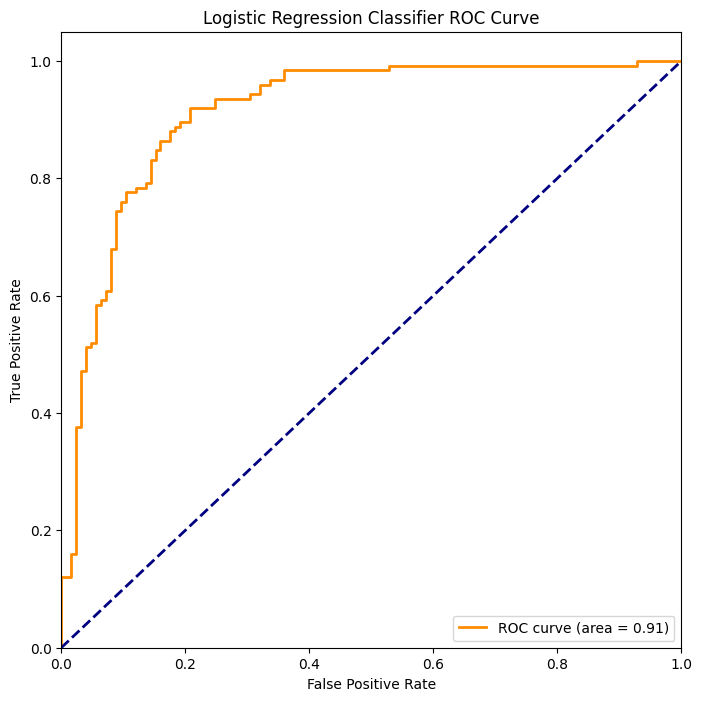

In [56]:
get_AUC_ROC_curve(LogisticRegression(), model_name='Logistic Regression Classifier')

Please close the graphic to continue


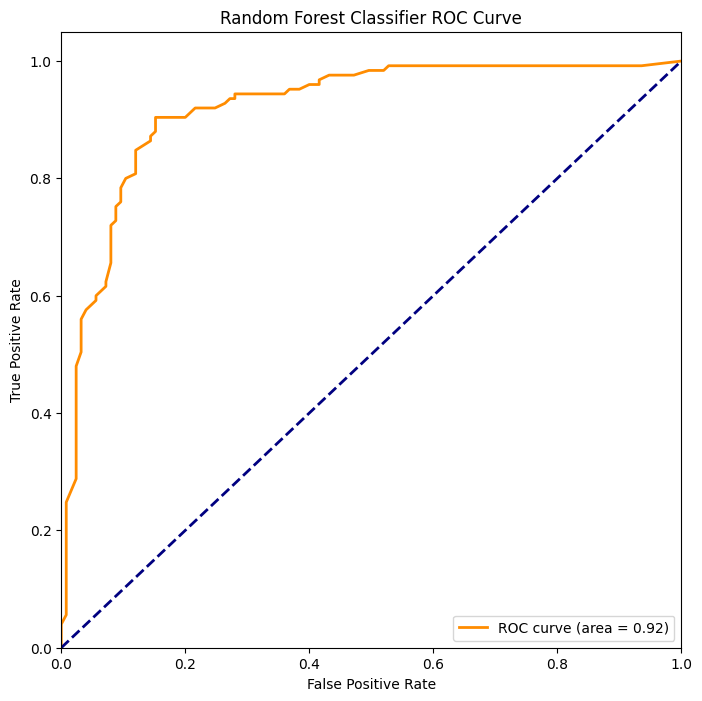

In [57]:
get_AUC_ROC_curve(RandomForestClassifier(), model_name='Random Forest Classifier')

Please close the graphic to continue


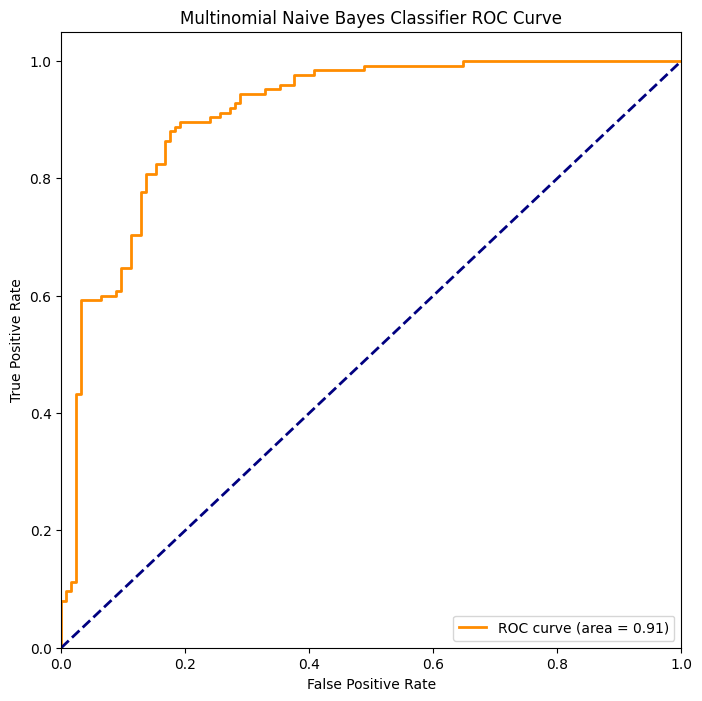

In [58]:
get_AUC_ROC_curve(MultinomialNB(), model_name='Multinomial Naive Bayes Classifier')

Please close the graphic to continue


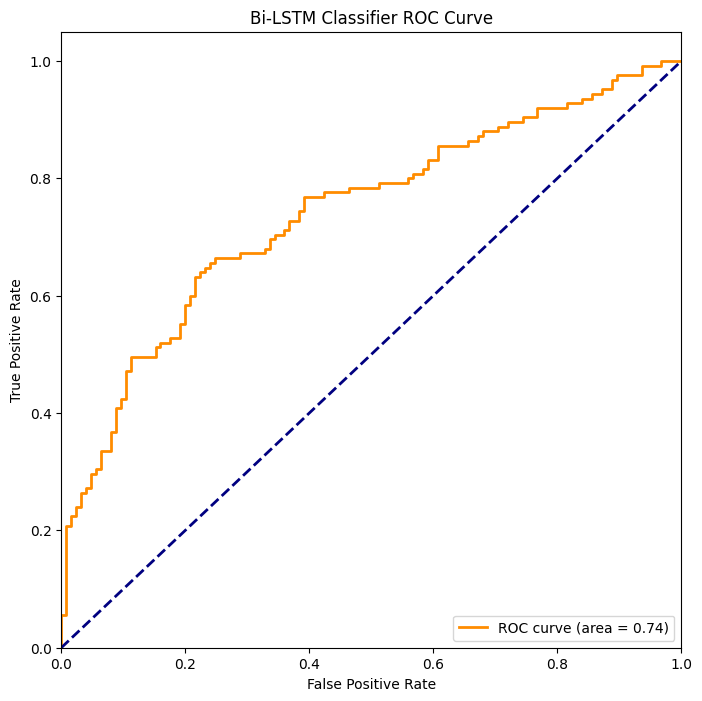

In [59]:
biLSTM_model = BiLSTMModel(input_size=X_train_tensor.shape[2], # This is the number of features (i.e., the TF-IDF size)
                            hidden_size=64, # Hidden units in LSTM
                            output_size=1 # Binary output (0 or 1)
                            )

get_AUC_ROC_curve(biLSTM_model, model_name='Bi-LSTM Classifier')

## 1.7 Conclusion

For the purpose of the Conclusion, I think it is useful to visualize the average final metrics again. In particular I want to describe how this project helped me learn about the limitations and potential pitfalls of using neural networks, and why certain techniques are better than others regarding methods of vectorization.

In [62]:
print('Displaying Averaged Model Metrics: \n')
print(final_average_metrics)

Displaying Averaged Model Metrics: 

               Logistic_Regression  Random_Forest_Classifier  Naive_Bayes  \
TP                      103.500000                 87.600000   112.000000   
TN                       98.000000                109.600000    84.100000   
FP                       27.000000                 15.400000    40.900000   
FN                       21.500000                 37.400000    13.000000   
TPR                       0.827965                  0.700305     0.895665   
TNR                       0.783140                  0.875911     0.672177   
FPR                       0.216860                  0.124089     0.327823   
FNR                       0.172035                  0.299695     0.104335   
Precision                 0.792594                  0.850530     0.731599   
F1_measure                0.809505                  0.767279     0.805006   
Accuracy                  0.806000                  0.788800     0.784400   
Error_rate                0.194000     

My Classes are balanced, so accuracy is not necessarily a bad measure here. Of the three models: Random_Forest_Classifier, Naive_Bayes, and Bi-LSTM, the non-neural network methods are much closer to ideal than the Bi-LSTM model tends to be.

### Summary of Model Performance Metrics

| Metric              | Logistic Regression | Random Forest | Naive Bayes | Bi-LSTM   |
|---------------------|---------------------|---------------|-------------|-----------|
| **True Positives (TP)** | 103.5               | 87.6          | 112.0       | 62.6      |
| **True Negatives (TN)** | 98.0                | 109.6         | 84.1        | 85.3      |
| **False Positives (FP)** | 27.0               | 15.4          | 40.9        | 39.7      |
| **False Negatives (FN)** | 21.5               | 37.4          | 13.0        | 62.4      |
| **True Positive Rate (TPR)** | 0.828           | 0.700         | 0.896       | 0.495     |
| **True Negative Rate (TNR)** | 0.783           | 0.876         | 0.672       | 0.680     |
| **False Positive Rate (FPR)** | 0.217           | 0.124         | 0.328       | 0.320     |
| **False Negative Rate (FNR)** | 0.172           | 0.300         | 0.104       | 0.505     |
| **Precision**         | 0.793               | 0.851         | 0.732       | 0.541     |
| **F1 Measure**        | 0.810               | 0.767         | 0.805       | 0.457     |
| **Accuracy**          | 0.806               | 0.789         | 0.784       | 0.592     |
| **Error Rate**        | 0.194               | 0.211         | 0.216       | 0.408     |
| **Balanced Accuracy (BACC)** | 0.806         | 0.788         | 0.784       | 0.588     |
| **True Skill Statistic (TSS)** | 0.611       | 0.576         | 0.568       | 0.175     |
| **Heidke Skill Score (HSS)** | 0.610         | 0.576         | 0.567       | 0.173     |
| **Brier Score (BS)**  | 0.170               | 0.153         | 0.166       | 0.248     |
| **Brier Skill Score (BSS)** | 0.684          | 0.615         | 0.670       | 1.000     |
| **Negative Predictive Value (NPV)** | 0.819    | 0.745         | 0.864       | 0.658     |
| **False Discovery Rate (FDR)** | 0.207       | 0.149         | 0.268       | 0.259     |
| **ROC AUC Score**     | 0.877               | 0.875         | 0.880       | 0.729     |


I think that false positives and false negatives are equally important in this data, because as a subset with equally distributed classes, we don't want to over-predict either, as it could result in missing a lot of insincere comments or potentially the deletion/removal of a lot of sincere questions. Neither is ideal, at least within the confines of the subset.

When relating it to the original dataset, however, there is a massive class imbalance. I believe it is something like over 90% of the original data consists of sincere questions. This presents quite a problem, because overpredicting False Positives would lead to many more unjustifiable question removals, and might end up hurting site engagement more than helping it (which is presumably the aim of trying to detect/remove insincere questions).

That means that in my opinion, a good classifier has to be balanced, if not slightly properly overpredicting True Negatives at the cost of underpredicting False Negatives.

Basically, a good classifier for this problem should prioritize allowing as many sincere questions through as it can whilst progressively seeking to discover insincere questions. This should be done without an marked increase in False Positives so that there is no sweeping mass auto-ban of people's valid, sincere questions.

With that in mind, I will look at a few key metrics:

Maximize TP: Naive Bayes

Minimize FP: Random Forest

Maximize TN: Random Forest

Minimize FN: Naive Bayes

TPR: Random Forest

TNR: Random Forest

Precision: Random Forest

Accuracy / BACC: Random Forest, Naive Bayes Tie (basically)


I think that in this case, because we want to minimize FP while gaining as much TP as we can, that means that we need to choose the classifier that performs the best at minimizing FP without costing TN, which means that in this case I would choose Random Forest.

Random Forest and Naive Bayes may basically tie on accuracy metrics, however they differ with respect to what they are able to detect. Random Forest is better at minimizing FP, which means that it more conservative with how it passes judgement on whether or not a question is insincere. Naive Bayes seems to be decent at maximizing the amount of positive classifications, which means that it is more aggressive than Random Forest. This might be okay if the original data was not so imbalanced, but given the imbalance this will be the worse choice, because in the context of the real world problem, this approach will result in many more detrimental total FP than it will advantageous total TP.

As a note; the reason that I did not even include the LSTM in this model is simple. My approach to this project utilizes tf-idf vectorization. This technique utilizes a generated voacbulary of sparse representations of word appearances to transform input sentences for model training.

This sparse representation works with models such as Naive Bayes and Random Forest, however it does not work with neural networks. This is because each of the vectors representing the sparse vocabulary term data has to be expanded into a dense vector before it can be utilized as input to a neural network. But this is the problem: when you expand a sparse vector/matrix, you make most of the values in the matrix/vector equal to zero. So I did this, and it basically results in a total loss of any discernable information for the input sentences. This obviously results in a total loss of ability for the neural network to learn any patterns, which is exactly what happens above. Upon closer examination of the neural network when computing the brier score / brier skill score, it becomes obvious that the model is not learning, because the probabilities that it outputs are basically the equivalent of a coin flip with added noise for every fold of training. I appreciate learning this here rather than in a professional setting.

## 1.8 END OF PROJECT